<a href="https://colab.research.google.com/github/pritkudale/Code_for_LinkedIn/blob/main/Linear_vs_Logistic_Regression_Animation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

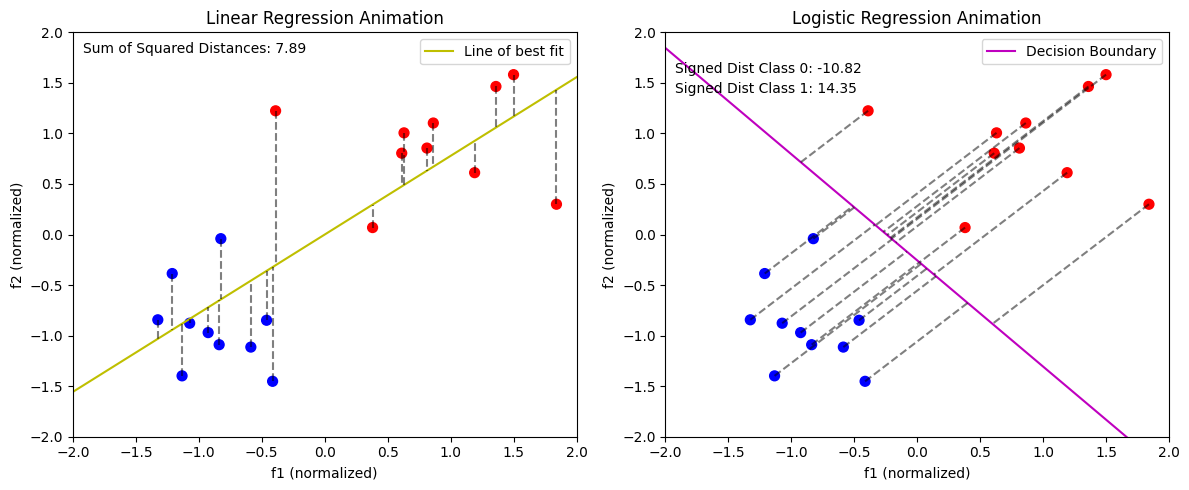

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.linear_model import LinearRegression, LogisticRegression

# Generate synthetic data
np.random.seed(0)
class_1 = np.random.multivariate_normal([2, 3], [[0.8, 0], [0, 0.8]], 10)
class_2 = np.random.multivariate_normal([6, 7], [[0.8, 0], [0, 0.8]], 10)

data = np.vstack([class_1, class_2])
labels = np.array([0] * len(class_1) + [1] * len(class_2))

# Normalize data
data_mean = np.mean(data, axis=0)
data_std = np.std(data, axis=0)
data = (data - data_mean) / data_std

# Gradient Descent for Linear Regression
def gradient_descent_linear(data, labels, lr=0.1, epochs=100):
    m, b = np.random.rand(), np.random.rand()  # Random initialization
    n = len(data)
    m_vals, b_vals = [m], [b]  # For tracking the evolution
    for _ in range(epochs):
        predictions = m * data[:, 0] + b
        error = predictions - data[:, 1]
        m_grad = (2/n) * np.sum(error * data[:, 0])
        b_grad = (2/n) * np.sum(error)
        m -= lr * m_grad
        b -= lr * b_grad
        m_vals.append(m)
        b_vals.append(b)
    return m, b, m_vals, b_vals

# Gradient Descent for Logistic Regression
def sigmoid(z):
    return np.clip(1 / (1 + np.exp(-z)), 1e-7, 1 - 1e-7)  # Prevent overflow

def gradient_descent_logistic(data, labels, lr=0.1, epochs=100):
    weights = np.random.rand(data.shape[1])
    bias = np.random.rand()
    weight_vals, bias_vals = [weights.copy()], [bias]  # For tracking
    for _ in range(epochs):
        linear_model = np.dot(data, weights) + bias
        predictions = sigmoid(linear_model)
        error = predictions - labels
        weights_grad = np.dot(data.T, error) / len(data)
        bias_grad = np.sum(error) / len(data)
        weights -= lr * weights_grad
        bias -= lr * bias_grad
        weight_vals.append(weights.copy())
        bias_vals.append(bias)
    return weights, bias, weight_vals, bias_vals

# Compute best fit lines and track progress
m_linear, b_linear, m_vals, b_vals = gradient_descent_linear(data, labels)
weights_logistic, bias_logistic, weight_vals, bias_vals = gradient_descent_logistic(data, labels)

# Decision boundary function for logistic regression
def decision_boundary(x, weights, bias):
    return -(weights[0] * x + bias) / weights[1]

# Perpendicular projection onto the decision boundary
def signed_distance(x, y, weights, bias):
    return (weights[0] * x + weights[1] * y + bias) / np.linalg.norm(weights)

# Create the figures and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --- Figure 1 ---
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.set_xlabel("f1 (normalized)")
ax1.set_ylabel("f2 (normalized)")
ax1.set_title("Linear Regression Animation")
scatter1 = ax1.scatter(data[:, 0], data[:, 1], c=labels, cmap='bwr', s=50)
line_linear1, = ax1.plot([], [], 'y-', label='Line of best fit')
error_text1 = ax1.text(0.02, 0.95, '', transform=ax1.transAxes)  # Text for sum of squared distances
error_lines1 = []  # Initialize list for error lines
for x, y in data:
    line, = ax1.plot([], [], 'k--', alpha=0.5)  # Create dotted lines
    error_lines1.append(line)  # Add lines to the list
ax1.legend()

# --- Figure 2 ---
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax2.set_xlabel("f1 (normalized)")
ax2.set_ylabel("f2 (normalized)")
ax2.set_title("Logistic Regression Animation")
scatter2 = ax2.scatter(data[:, 0], data[:, 1], c=labels, cmap='bwr', s=50)
line_logistic2, = ax2.plot([], [], 'm-', label='Decision Boundary')
error_text2_class0 = ax2.text(0.02, 0.90, '', transform=ax2.transAxes)
error_text2_class1 = ax2.text(0.02, 0.85, '', transform=ax2.transAxes)
error_lines2 = []  # Initialize list for error lines
for x, y in data:
    line, = ax2.plot([], [], 'k--', alpha=0.5)  # Create dotted lines
    error_lines2.append(line)  # Add lines to the list
ax2.legend()

# Define animation function
def animate(i):
    # --- Figure 1 Animation ---
    x_vals = np.linspace(-2, 2, 100)
    y_vals = m_vals[i] * x_vals + b_vals[i]
    line_linear1.set_data(x_vals, y_vals)

    sum_sq_dist1 = 0
    for j, (x, y) in enumerate(data):
        y_pred = m_vals[i] * x + b_vals[i]
        error_lines1[j].set_data([x, x], [y, y_pred])
        sum_sq_dist1 += (y - y_pred) ** 2
    error_text1.set_text(f"Sum of Squared Distances: {sum_sq_dist1:.2f}")

    # --- Figure 2 Animation ---
    x_vals = np.linspace(-2, 2, 100)
    y_vals = decision_boundary(x_vals, weight_vals[i], bias_vals[i])
    line_logistic2.set_data(x_vals, y_vals)

    signed_dist_class0 = 0
    signed_dist_class1 = 0
    for j, (x, y) in enumerate(data):
        signed_dist = signed_distance(x, y, weight_vals[i], bias_vals[i])
        if labels[j] == 0:
            signed_dist_class0 += signed_dist
        else:
            signed_dist_class1 += signed_dist
        x_proj = x - signed_dist * weight_vals[i][0] / np.linalg.norm(weight_vals[i])
        y_proj = y - signed_dist * weight_vals[i][1] / np.linalg.norm(weight_vals[i])
        error_lines2[j].set_data([x, x_proj], [y, y_proj])
    error_text2_class0.set_text(f"Signed Dist Class 0: {signed_dist_class0:.2f}")
    error_text2_class1.set_text(f"Signed Dist Class 1: {signed_dist_class1:.2f}")

    return line_linear1, line_logistic2, *error_lines1, *error_lines2, error_text1, error_text2_class0, error_text2_class1

# Create animation
ani = FuncAnimation(fig, animate, frames=len(m_vals), interval=200, blit=True)

# Save or show the animation (uncomment one)
ani.save('logistic_vs_linear_signed_distances.gif', writer='imagemagick')
plt.tight_layout()
plt.show()
